# Append Features

## [Introduction and Overview](#Introduction)
## [Import the Libraries](#Import-Libraries)
## [Make a GIS Connection](#Make-a-GIS-Connection)
## [Append new features from a File Geodatabase](#Append-new-features-from-File-Geodatabase)
 * [Download the target feature layer data](#Download-the-Downingtown-target-feature-layer-datata)
 * [Publish the target feature layer](#Publish-the-target-Downingtown-hosted-feature-layer)
 * [Visualize the target feature layer](#Visualize-the-Downingtown-feature-layer)
 * [Get the source item for appending](#Get-the-source-Downingtown-subdivision-item-for-appending)
 * [Append features from source file geodatabase item](#Append-the-features)
 * [Verify new features](#Verify-Append)

## [Insert attribute values from a CSV](#Append-attribute-values-from-a-CSV-to-a-Feature-Layer)
  * [Download the source `csv` data](#Download-the-source-csv-data)
  * [Add source `csv` item to the GIS](#Add-the-source-csv-item-to-the-GIS)
  * [Analyze the source `csv` item](#Analyze-the-source-csv-item)
  * [Download the target feature layer data](#Download-the-target-feature-layer-data)
  * [Manage the target feature layer schema](#Manage-target-feature-layer-schema)
  * [Publish the target feature layer](#Publish-target-countries-hosted-feature-layer)
  * [Get the target feature layer](#Get-the-target-hosted-feature-layer)
  * [Add an attribute field to the target feature layer](#Add-attribute-field-to-the-target-hosted-feature-layer)
  * [Add a unique index to the new attribute field](#Add-a-unique-index-to-the-new-attribute-field)
  * [Append values from the source `csv` to the target feature layer](#Append-attribute-values-from-the-csv-item-into-target-feature-layer-attribute-field)
  
## [Insert new features and update (`upsert`) attribute values from a File Geodatabase](#Insert-New-Features-and-Update-Existing-Features---Upsert)
 * [Download the target feature layer data](#Download-the-target-Sierra-Leone-feature-layer-data)
 * [Publish the hosted feature layer](#Publish-the-Sierra-Leone-target-hosted-feature-layer)
 * [Visualize the target hosted feature layer](#Visualize-the-target-feature-layer)
 * [Query the target hosted feature layer ](#Query-the-feature-layer-to-examine-attribute-errors)
 * [Examine attribute fields and indices](#Examine-attribute-fields-and-indices)
 * [Examine the source file geodatabase item](#Examine-the-source-file-geodatabase)
 * [Append using `upsert`](#Append-using-upsert-to-update-attribute-values-and-add-new-features)
 
### [In Conclusion](#Conclusion)

##  Introduction and Overview

Any Web GIS Administrator can attest to the fundamental importance of managing hosted feature layers in ArcGIS online. Adding data en masse to existing hosted feature layers typically involved a three step process of downloading the feature layer data, merging additional edits, then overwriting the original feature layer. While that workflow suffices in many circumstances, the [`append()`](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#arcgis.features.FeatureLayer.append) function greatly simplifies the process. It saves a ton of time if your features layers are large, eliminating the time involved in overwriting the feature layer. 

Let's take a look at some example `append()` workflows below.  This guide document refers to the feature layer you will append data into as the `target`, while the item you append data from is referred to as the `source`.

## Import Libraries

In [1]:
import os
import zipfile
import datetime as dt
from copy import deepcopy

from arcgis.gis import GIS
from arcgis.features import GeoAccessor
import arcpy

##### Helper Function
Throughout this notebook, you'll download items from an ArcGIS Online Organizational portal. You'll subsequently publish these items with a unique timestamp to distinguish the resulting service from any other service owned by the login you employ in this guide. Service names need to be unique across an organization and the function below will add a unique timestamp to the end of item names so the service you publish is unique and owned by you.

In [2]:
def now_dt():
    return str(int(dt.datetime.now().timestamp()))

### Make a GIS Connection

In [3]:
gis = GIS(profile="your_online_profile")

## Append new features from File Geodatabase

This first example appends new features from a File Geodatabase into a hosted feature layer. For best performance and reducing the chance of errors when using [`append()`](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#arcgis.features.FeatureLayer.append), Esri strongly recommends the schema for the source file (source) to upload matches the schema of the hosted feature service layer (target).  

In this first section, the schema match between a File Geodatabase item, named `SubDiv_PB11_PG48_parcels`, and a hosted feature service layer you will publish.

#### Download the Downingtown target feature layer data

The Downingtown Parcels File Geodatabase item exists in the GIS. You'll download the file geodatabase item containing the data you want to publish as a feature layer. 

<Item title:"Downingtown_PA_Parcels" type:File Geodatabase owner:api_data_owner>
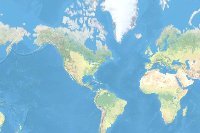

In [4]:
downingtown_parcels_fgdb = gis.content.search('title:Downingtown_PA_Parcels owner:api_data_owner', 
                                              item_type='File Geodatabase')[0]
downingtown_parcels_fgdb

You can use Python's `os` module to ensure you know where the code downloads files. By default, the file downloads to the current working directory as returned by `os.getcwd()`. Use `os.chdir(path_to_your_directory)` to change the current working directory to where you want files to download. For example, you could assign variables for specific paths on your file system like below:

* `cwd = os.getcwd()`
* `wd = os.path.join(cwd, "append_guide")`
* `os.chdir(wd)`

The rest of the guide will use the `wd` variable as the working directory to manage data downloads for the exercise. You can choose to follow the example, or manage downloads in a way that works best for you.

In [13]:
wd = os.getcwd()

In [14]:
if not os.path.exists(os.path.join(wd, "downingtown")):
    os.mkdir(os.path.join(wd, "downingtown"))

# Assign a variable to the full path of the new directory to use as your working directory
wd = os.path.join(wd, "downingtown")

Extract the file geodatabase. The `save_path` and `file_name` parameters will be unique to you and your system. The paths and names used in this guide are solely for demonstration purposes.

In [15]:
downingtown_zip = downingtown_parcels_fgdb.download(save_path=wd, file_name="downingtown_fgdb_"
                                                    + now_dt() + ".zip")

#### Publish the target Downingtown hosted feature layer
Set properties for a new item, then add it to the portal with the zip file as the `data` argument. Publish the item to create a hosted feature layer your login owns to work though this guide. 

In [16]:
downingtown_props = {"title":"Downingtown_PA_Parcels_" + now_dt(),
                   "type":"File Geodatabase",
                   "tags":"Downingtown PA, Pennsylvania, local government, \
                   parcel management",
                   "snippet":"Parcel data for the municipality of Downingtown, \
                   Pennsyslvania in the United States.",
                   "description":"Data downloaded from Chester County, PA \
                   Open Data https://data1-chesco.opendata.arcgis.com"}

if not "Downingtown" in [folder['title'] for folder in gis.users.me.folders]:
    gis.content.create_folder("Downingtown")

downingtown_fgdb_item = gis.content.add(item_properties=downingtown_props,
                                        data=downingtown_zip,
                                        folder="Downingtown")
downingtown_item = downingtown_fgdb_item.publish()

In [17]:
downingtown_item.title

'Downingtown_PA_Parcels_1559344876'

#### Visualize the Downingtown feature layer

In [18]:
downingtown_fl = downingtown_item.layers[0]
downingtown_fl

<FeatureLayer url:"https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/Downingtown_PA_Parcels_1559344876/FeatureServer/0">

In [19]:
downingtown_fl.query(return_count_only=True)

2548


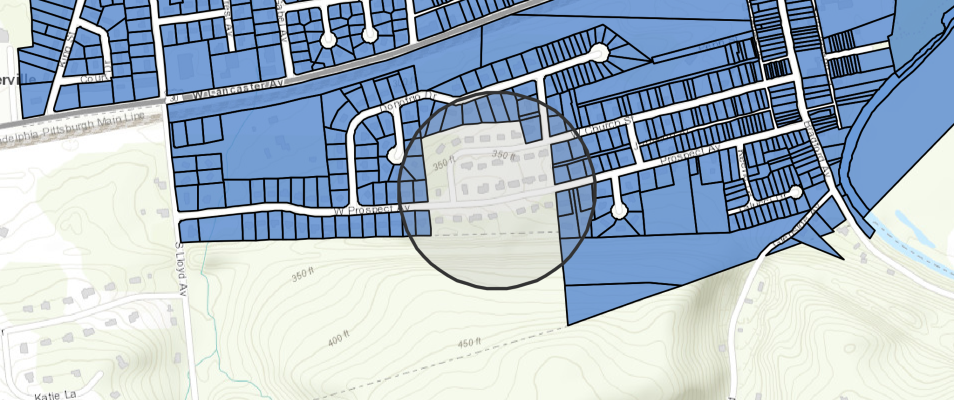

In [23]:
m = gis.map("Downingtown, PA")
m.center = [40.0065, -75.7033]
m.zoom = 14
m

In [19]:
m.add_layer(downingtown_fl)

We'll zoom in to a particular part of Downingtown where a new subdivision has been build but has not been added to the feature layer. (Observe the empty square-shaped section in the map after running the cell below.

In [20]:
m.zoom = 16
m.center = [39.9975, -75.7173]

Query the Feature for a specific subdivision. Currently, there are no features for this subdivision. You will be adding the features for subdivision as _PB 11 PG 48_ to the parcels feature layer for Downingtown, PA using the append features workflow.

In [20]:
downingtown_fl.query(where="SUBDIV_NUM = 'PB 11 PG 48'")

<FeatureSet> 0 features

#### Get the source Downingtown subdivision item for appending
For the append workflow to work, you need to add the source file containing the new features as an Item in your GIS. In this case this file is already uploaded as an Item for you. Next, get the item id value for this file geodatabase item containing features you want to append to the feature layer. In this case, the Schema from the file geodatabase you'll append matches the hosted feature layer.

In [23]:
down_subdiv_fgdb_item = gis.content.search(query="title:SubDiv* owner:api_data_owner", item_type="File Geodatabase")[0]

In [25]:
subdiv_id = down_subdiv_fgdb_item.id
subdiv_id

'4181764cd26b4dc0bea29dda673c0c7e'

#### `Append` the features
To update the target `FeatureLayer` object with a new set of features, you can call the `append()` method on it and give it the source `Item` containing the new set of features.

Run `append` with the appropriate parameters to add the subdivision features from the file geodatabase item . Since the file geodatabase schema matches the schema of Downingtown parcels Feature Layer, only the `source_table_name` from the file geodatabase item is needed to insert new features.

In [26]:
downingtown_fl.append(item_id=subdiv_id, 
                      upload_format='filegdb',
                      source_table_name='subdiv_pb_11_pg_48')

True

#### Verify the append 
We see a message of `True`.

Query the feature layer and then visualize it to verify results.

In [27]:
downingtown_fl.query(where="SUBDIV_NUM = 'PB 11 PG 48'")

<FeatureSet> 28 features

_Display layer with appended Features_

We'll retrieve the layer again from out portal and added it to a new map to verify the new features were added.


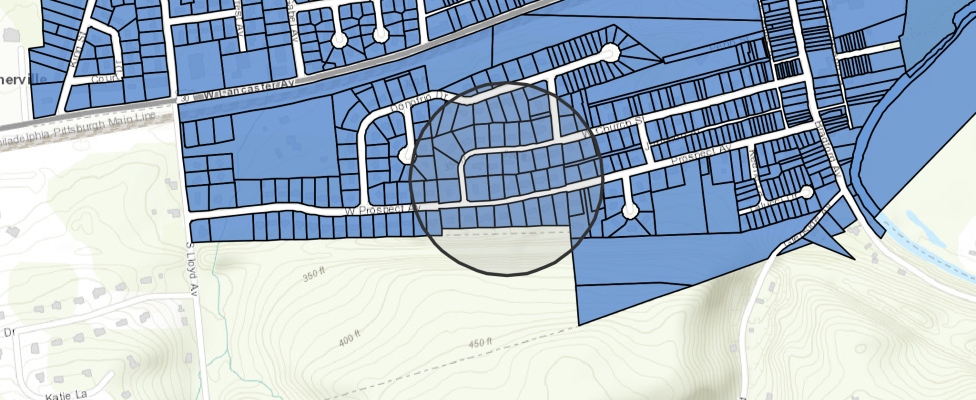

In [34]:
m2 = gis.map("Downingtown, PA")
m2.center = [40.0065, -75.7033]
m2.zoom = 14
m2

In [30]:
m2.zoom = 16
m2.center = [39.9975, -75.7173]

In [31]:
m2.add_layer(downingtown_fl)

## Append attribute values from a CSV into a new column on a Feature Layer
You'll now use `append` to update attribute values in a hosted feature layer from a `csv` item. In this case, the schemas **do not** match between the `csv` file (that you will upload as an item) and the hosted feature service layer you want to append values into.  

Instead, you will add a new attribute field to the existing hosted feature service layer, and then use the `append()` parameter `field_mappings` to indicate how fields align between the source item and target feature service layer. In addition to the `field_mappings` parameter to indicate which fields align, you'll also use the `append_fields` parameter to further restrict the operation to indicate which field you want to update.

In [28]:
# Create a working directory
if not os.path.exists(os.path.join(wd, "country")):
    os.mkdir(os.path.join(wd, "country"))

# Assign a variable to the full path of the new directory
wd = [os.path.join(wd, dir) 
      for dir in os.listdir(wd) 
      if 'country' in dir][0]

#### Download the source `csv` data

Search for and download the csv item so you can add it the portal as the owner of the item. You need to own a csv item to [`analyze()`](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html#arcgis.gis.ContentManager.analyze) it. The results from analyzing are required for the `source_info` parameter in the `append` function.

<Item title:"World_Sovereignty" type:CSV owner:api_data_owner>
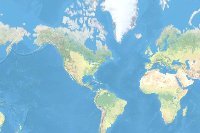

In [30]:
sov_csv = gis.content.search("title:World_Sovereignty owner:api_data_owner", item_type="CSV")[0]
sov_csv

In [42]:
sov_csv.download(save_path=wd, file_name="countries_" + now_dt() + ".csv")

country_csv = [os.path.join(wd, csv) 
               for csv in os.listdir(wd) 
               if csv.endswith(".csv")][0]
country_csv

'DRIVE:\\\\Path\\To\\Data\\append_guide\\country\\countries_1558729983.csv'

#### Add the source `csv` item to the GIS

In [33]:
world_sov_props = {"title":"world_sovereignty_" + now_dt(),
                   "type":"CSV",
                   "tags":"indepedence, politics, international boundaries, geopolitics",
                   "snippet":"Data about the sovereignty of many of the world's nations",
                   "description":"Data collected from wikipedia regarding national sovereignty across the world"}

if not "World Sovereignty" in [folder['title'] 
                               for folder in gis.users.me.folders]:
                           gis.content.create_folder("World Sovereignty")

ws_item = gis.content.add(item_properties=world_sov_props,
                         data=country_csv,
                         folder="World Sovereignty")
ws_item.id

'4a4b5ba1df424dccb36b13f7cd09b8e2'

#### Analyze the source `csv` item 
The `publishParameters` key value resulting from analyzing the csv file is necessary as the `source_info` parameter when `appending` from a csv file.

In [35]:
source_info = gis.content.analyze(item=ws_item.id, file_type='csv', location_type='none')
source_info['publishParameters']

{'type': 'csv',
 'name': 'data',
 'useBulkInserts': True,
 'sourceUrl': '',
 'locationType': 'none',
 'maxRecordCount': 1000,
 'columnDelimiter': ',',
 'qualifier': '"',
 'targetSR': {'wkid': 102100, 'latestWkid': 3857},
 'editorTrackingInfo': {'enableEditorTracking': False,
  'enableOwnershipAccessControl': False,
  'allowOthersToQuery': True,
  'allowOthersToUpdate': True,
  'allowOthersToDelete': False,
  'allowAnonymousToQuery': True,
  'allowAnonymousToUpdate': True,
  'allowAnonymousToDelete': True},
 'layerInfo': {'currentVersion': 10.61,
  'id': 0,
  'name': '',
  'type': 'Table',
  'displayField': '',
  'description': '',
  'copyrightText': '',
  'defaultVisibility': True,
  'relationships': [],
  'isDataVersioned': False,
  'supportsAppend': True,
  'supportsCalculate': True,
  'supportsASyncCalculate': True,
  'supportsTruncate': False,
  'supportsAttachmentsByUploadId': True,
  'supportsAttachmentsResizing': True,
  'supportsRollbackOnFailureParameter': True,
  'supportsSta

From the results of the `analyze` function, we can list the field headings from the `csv` file behind the csv item. We want to know the names of the headings so we know what to enter for `source` parameter values in the `field_mappings` parameter of the `append` function:

In [36]:
for csv_field in source_info['publishParameters']['layerInfo']['fields']:
    print(csv_field['name'])

Country
Continent
First_acquisition_of_sovereignty
Date_of_last_subordination
Previous_governing_power
Notes


#### Download the target feature layer data 
Search for a shapefile on the portal named `International Boundaries`. You'll download this shapefile, perform some cleanup to simplify the data, and create a spatially enabled dataframe from it. You will publish a unique hosted feature layer that you own to investigate appending values from a csv file into a hosted feature layer.

<Item title:"International Boundaries" type:Shapefile owner:api_data_owner>
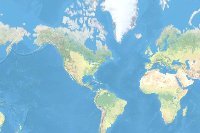

In [37]:
country_boundaries_shp = gis.content.search("title:International Bound* owner:api_data_owner",
                                           item_type='Shapefile')[0]
country_boundaries_shp

Download the data and extract the shapefile from the zip archive. 

In [38]:
country_zip = country_boundaries_shp.download(
                                    save_path=wd, 
                                    file_name="countries_" + now_dt() + 
                                    ".zip")

with zipfile.ZipFile(country_zip, 'r') as zf:
    zf.extractall(wd)

Extracting the shapefile in the previous cell created a new directory in the current working directory. We store the path to this directory for use later.

In [48]:
countries_shp = [os.path.join(wd, "countries", shp) 
                 for shp in os.listdir(os.path.join(wd, "countries"))
                 if shp.endswith(".shp")][0]
countries_shp

'DRIVE:\\\\Path\\To\\Data\\append_guide\\country\\countries\\countries.shp'

#### Manage target feature layer schema

Load the shapefile into a Spatially Enabled DataFrame and remove unwanted columns from the source data.

In [40]:
countries_sedf = GeoAccessor.from_featureclass(countries_shp)
countries_sedf.head()

,FID,OBJECTID,NAME,ISO3,ISO2,FIPS,COUNTRY,ENGLISH,FRENCH,SPANISH,LOCAL,FAO,WAS_ISO,SOVEREIGN,CONTINENT,UNREG1,UNREG2,EU,SQKM,SHAPE
0,0,1,Åland,ALA,AX,AX,Åland,Åland,,,Åland,,,Finland,Europe,Northern Europe,Europe,0,1.243719e+03,"{""rings"": [[[20.995666505473764, 60.6422767616..."
1,1,2,Afghanistan,AFG,AF,AF,Afghanistan,Afghanistan,Afghanistan,Afganistán,Afghanestan,Afghanistan,,Afghanistan,Asia,Southern Asia,Asia,0,6.413834e+05,"{""rings"": [[[73.2733612030425, 36.888557437342..."
2,2,3,Albania,ALB,AL,AL,Albania,Albania,Albanie,Albania,Shqiperia,Albania,,Albania,Europe,Southern Europe,Europe,0,2.848611e+04,"{""rings"": [[[20.98056793146918, 40.85522079417..."
3,3,4,Algeria,DZA,DZ,AG,Algeria,Algeria,Algérie,Argelia,Al Jaza'ir,Algeria,,Algeria,Africa,Northern Africa,Africa,0,2.316559e+06,"{""rings"": [[[-8.673868179321232, 27.2980728170..."
4,4,5,American Samoa,ASM,AS,AQ,American Samoa,American Samoa,Samoa Américaines,Samoa Americana,American Samoa,American Samoa,,United States,Oceania,Polynesia,Oceania,0,2.110151e+02,"{""rings"": [[[-171.07492065386455, -11.06859588..."


Remove unwanted columns.

> **NOTE:** If running in an environment without `arcpy`, the `FID` value below will report as `index`. Change `FID` to `index` in the list to run the cell.

In [41]:
countries_sedf.drop(labels=["FID","WAS_ISO", "FIPS","ENGLISH","FRENCH","SPANISH"], axis=1, inplace=True)
countries_sedf.head()

,OBJECTID,NAME,ISO3,ISO2,COUNTRY,LOCAL,FAO,SOVEREIGN,CONTINENT,UNREG1,UNREG2,EU,SQKM,SHAPE
0,1,Åland,ALA,AX,Åland,Åland,,Finland,Europe,Northern Europe,Europe,0,1.243719e+03,"{""rings"": [[[20.995666505473764, 60.6422767616..."
1,2,Afghanistan,AFG,AF,Afghanistan,Afghanestan,Afghanistan,Afghanistan,Asia,Southern Asia,Asia,0,6.413834e+05,"{""rings"": [[[73.2733612030425, 36.888557437342..."
2,3,Albania,ALB,AL,Albania,Shqiperia,Albania,Albania,Europe,Southern Europe,Europe,0,2.848611e+04,"{""rings"": [[[20.98056793146918, 40.85522079417..."
3,4,Algeria,DZA,DZ,Algeria,Al Jaza'ir,Algeria,Algeria,Africa,Northern Africa,Africa,0,2.316559e+06,"{""rings"": [[[-8.673868179321232, 27.2980728170..."
4,5,American Samoa,ASM,AS,American Samoa,American Samoa,American Samoa,United States,Oceania,Polynesia,Oceania,0,2.110151e+02,"{""rings"": [[[-171.07492065386455, -11.06859588..."


#### Publish target countries hosted feature layer 
Use the `to_featurelayer()` method on the spatially enabled dataframe, then move the Feature Layer and underlying File Geodatabase item to the desired folder in the GIS.

> **NOTE:** The first time you use the `to_featurelayer()` method to publish a Spatially Enabled DataFrame in a conda environment with `arcpy` installed, you may receive a warning message `ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().` Most often this is just a warning and the feature layer published correctly. Check the portal to ensure the layer was created.

In [51]:
countries_item = countries_sedf.spatial.to_featurelayer(title="world_boundaries_" + now_dt(),
                                                      gis=gis,
                                                      tags="Administrative Boundaries, International, Geopolitics")
countries_item.move(folder="World Sovereignty")

countries_shp_item = [item for item in gis.content.search("*", item_type="File Geodatabase")
                      if item.title == countries_item.title][0]
countries_shp_item.move(folder="World Sovereignty")

{'success': True,
 'itemId': '017beebf2b7849cebef7f024b19e3dbb',
 'owner': 'arcgis_python',
 'folder': '43b7f217d2d541e1944207a96eb2b1a0'}

#### Get the target hosted feature layer

In [52]:
world_boundaries_item = [c for 
                         c in gis.content.search(query="world_boundaries* \
                                                 AND owner:arcgis_python",
                                                item_type="Feature Layer")][0]
world_boundaries_item

<Item title:"world_boundaries_1558730141" type:Feature Layer Collection owner:arcgis_python>

#### Add attribute field to the target hosted feature layer
List all the current fields in the layer so you can use one as a field template. You'll create a copy from the template, edit its values, then add that field to the layer with the `add_to_definition()` method.

In [53]:
boundaries_lyr = world_boundaries_item.layers[0]

for field in boundaries_lyr.properties.fields:
    print(f"{field['name']:30}{field['type']}")

OBJECTID                      esriFieldTypeOID
NAME                          esriFieldTypeString
ISO3                          esriFieldTypeString
ISO2                          esriFieldTypeString
COUNTRY                       esriFieldTypeString
LOCAL                         esriFieldTypeString
FAO                           esriFieldTypeString
SOVEREIGN                     esriFieldTypeString
CONTINENT                     esriFieldTypeString
UNREG1                        esriFieldTypeString
UNREG2                        esriFieldTypeString
EU                            esriFieldTypeInteger
SQKM                          esriFieldTypeDouble
Shape__Area                   esriFieldTypeDouble
Shape__Length                 esriFieldTypeDouble


Create a dictionary from a deep copy of a field in the feature layer, and update the values of this dictionary to reflect a new field:

In [54]:
dols_field = dict(deepcopy(boundaries_lyr.properties.fields[1]))
dols_field['name'] = "sovereignty_year"
dols_field['alias'] = "SOVEREIGNTY_YEAR"
dols_field['length'] = "10"
dols_field

{'name': 'sovereignty_year',
 'type': 'esriFieldTypeString',
 'alias': 'SOVEREIGNTY_YEAR',
 'sqlType': 'sqlTypeOther',
 'length': '10',
 'nullable': True,
 'editable': True,
 'domain': None,
 'defaultValue': None}

Update feature layer definition with the new field using the [`add_to_definition()`](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.managers.html#arcgis.features.managers.FeatureLayerCollectionManager.add_to_definition) method.

In [55]:
field_list = [dols_field]
boundaries_lyr.manager.add_to_definition({"fields":field_list})

{'success': True}

View the list of fields to verify the feature service layer contains the new field. You have to reload the layer in the notebook to reflect the change:

In [56]:
world_boundaries_item = gis.content.search(query="world_* AND owner:arcgis_python", 
                                           item_type="Feature Layer")[0]
world_boundaries_lyr = world_boundaries_item.layers[0]

for fld in world_boundaries_lyr.properties.fields:
    print(fld['name'])

OBJECTID
NAME
ISO3
ISO2
COUNTRY
LOCAL
FAO
SOVEREIGN
CONTINENT
UNREG1
UNREG2
EU
SQKM
Shape__Area
Shape__Length
sovereignty_year


#### Add a unique index to the new attribute field 

When appending data to a layer, you need a foreign key. Thus, any attribute field that matches values from the source csv to those in a hosted feature layer must have a unique index in the hosted feature layer field. The `name` field in the hosted feature layer matches values in the `Country` field in the csv table, so we need to uniquely index the `name` field.  

We'll list the fields in the layer that contain a unique index. 

In [57]:
uk_flds = [f.fields.lower() for f in boundaries_lyr.properties.indexes if f.isUnique]

for fld in boundaries_lyr.properties.fields:
    if fld.name.lower() in uk_flds:
        print(f"{fld.name:30}{fld.type:25}isUnique")
    else:
        print(f"{fld.name:30}{fld.type:25}")

OBJECTID                      esriFieldTypeOID         isUnique
NAME                          esriFieldTypeString      
ISO3                          esriFieldTypeString      
ISO2                          esriFieldTypeString      
COUNTRY                       esriFieldTypeString      
LOCAL                         esriFieldTypeString      
FAO                           esriFieldTypeString      
SOVEREIGN                     esriFieldTypeString      
CONTINENT                     esriFieldTypeString      
UNREG1                        esriFieldTypeString      
UNREG2                        esriFieldTypeString      
EU                            esriFieldTypeInteger     
SQKM                          esriFieldTypeDouble      
Shape__Area                   esriFieldTypeDouble      
Shape__Length                 esriFieldTypeDouble      


Create a copy of one index, then edit it to reflect values for a new index. Then add that to the layer definition.

In [58]:
uk_name_idx = dict(deepcopy(boundaries_lyr.properties['indexes'][0]))
uk_name_idx['name'] = 'c_name_uk'
uk_name_idx['fields'] = 'NAME'
uk_name_idx['isUnique'] = True
uk_name_idx['description'] = 'index_name'

uk_name_idx

{'name': 'c_name_uk',
 'fields': 'NAME',
 'isAscending': True,
 'isUnique': True,
 'description': 'index_name'}

In [59]:
index_list = [uk_name_idx]
boundaries_lyr.manager.add_to_definition({"indexes":index_list})

{'success': True}

Verify the index was added

In [60]:
world_boundaries_item = gis.content.search(query="world_* AND owner:arcgis_python", 
                                           item_type="Feature Layer")[0]
boundaries_lyr = world_boundaries_item.layers[0]

uk_flds = [f.fields.lower() for f in boundaries_lyr.properties.indexes if f.isUnique]

for fld in boundaries_lyr.properties.fields:
    if fld.name.lower() in uk_flds:
        print(f"{fld.name:30}{fld.type:25}isUnique")
    else:
        print(f"{fld.name:30}{fld.type:25}")

OBJECTID                      esriFieldTypeOID         isUnique
NAME                          esriFieldTypeString      isUnique
ISO3                          esriFieldTypeString      
ISO2                          esriFieldTypeString      
COUNTRY                       esriFieldTypeString      
LOCAL                         esriFieldTypeString      
FAO                           esriFieldTypeString      
SOVEREIGN                     esriFieldTypeString      
CONTINENT                     esriFieldTypeString      
UNREG1                        esriFieldTypeString      
UNREG2                        esriFieldTypeString      
EU                            esriFieldTypeInteger     
SQKM                          esriFieldTypeDouble      
Shape__Area                   esriFieldTypeDouble      
Shape__Length                 esriFieldTypeDouble      
sovereignty_year              esriFieldTypeString      


Create a Pandas dataframe and take a look at the first 25 records in the dataframe created from querying the feature layer. You can see the `sovereignty_year` column has no values for any of the records.

In [61]:
boundaries_df = boundaries_lyr.query(where="OBJECTID < 26", as_df=True)
boundaries_df[["OBJECTID", "NAME", "sovereignty_year"]]

,OBJECTID,NAME,sovereignty_year
0,1,Åland,None
1,2,Afghanistan,None
2,3,Albania,None
3,4,Algeria,None
4,5,American Samoa,None
5,6,Andorra,None
6,7,Angola,None
7,8,Anguilla,None
8,9,Antarctica,None
9,10,Antigua and Barbuda,None


#### Append attribute values from the `csv` item into target feature layer attribute field

You want to update the `sovereignty_year` field you added to the feature layer with values from the `Date_of_last_subordination` column in the `csv` item. 

You also know that the values in the hosted feature layer `NAME` attribute field, which you know has unique values, match the values in the `Country` field in the csv data.

When field names in the source and target tables vary, the `field_mappings` parameter of the append method allows you to match them. Thus, in this example, the `sovereignty_year` and `NAME` fields of the target feature layer differ from the `Date_of_last_subordination` and `Country` fields of the source CSV. The default behavior of the parameter is to match field names between the source and target, so if all headings and field names match, the parameter is optional. With field names that do not match, the parameter argument is a list of dictionaries, each dictionary pairing a `name` key for the target feature layer to a `source` key which is the corresponding field in the csv. 

The `append_fields` parameter can be used to further alter the default behavior and restrict which fields will be inserted, have values updated or matched. See the [`Append (Feature Service/Layer`](https://developers.arcgis.com/rest/services-reference/append-feature-service-layer-.htm) documentation for detailed explanations on all parameters. 

You want to update values in the `sovereignty_year` field, and match values in the `NAME` field, so each is entered as an argument in the `append_fields` parameter. The `upsert_matching_fields` parameter informs the server that when this layer field matches a record from the source field to which its mapped (in `field_mappings`), update the feature layer with values from the source according to the `append_fields` list.

In [62]:
boundaries_lyr.append(item_id=sov_csv.id,
                      upload_format = 'csv',
                      field_mappings = [{"name":"sovereignty_year", "source":"Date_of_last_subordination"},
                                        {"name":"NAME", "source":"Country"}],
                      source_info = source_info['publishParameters'],
                      upsert=True,
                      update_geometry=False,
                      append_fields=["sovereignty_year", "NAME"],
                      skip_inserts=True,
                      upsert_matching_field="NAME")

True

Look at the same 25 records to verify the `append` added attribute values.

In [63]:
app_boundaries_df = boundaries_lyr.query(where="OBJECTID < 26", as_df=True)
app_boundaries_df[["OBJECTID", "NAME", "sovereignty_year"]][:25]

,OBJECTID,NAME,sovereignty_year
0,1,Åland,None
1,2,Afghanistan,1823
2,3,Albania,1944
3,4,Algeria,1962
4,5,American Samoa,None
5,6,Andorra,1944
6,7,Angola,1975
7,8,Anguilla,None
8,9,Antarctica,None
9,10,Antigua and Barbuda,1981


## Insert New Features and Update Existing Features - Upsert

You'll now use the `append` to combine adding new features and correcting attribute value errors. This combination of adding new features (`insert`), and changing existing feature values (`update`) is known as an `upsert`. The `append` method includes the `field_mappings`, `upsert`,`skip_updates`, `skip_inserts`, `append_fields`, and `upsert_matching_field` parameters to provide you control over how the append occurs. 

In [66]:
# Create a working directory
if not os.path.exists(os.path.join(wd, "sierra_leone")):
    os.mkdir(os.path.join(wd, "sierra_leone"))

# Assign the full path of the new directory to a variable
wd = [os.path.join(wd, dir) 
      for dir in os.listdir(wd) 
      if 'sierra_leone' in dir][0]

#### Download the target Sierra Leone feature layer data
Search for a File Geodatabase of the West African Country of Sierra Leone.

For the purposes of illustrating the `append` function in this guide, the `arcgis_python` user needs to own a copy of the hosted feature layer to append data into. You'll download a File Geodatabase item as zip file then add it to the portal and publish a unique hosted feature service from that zip file.

<Item title:"Sierra_Leone_Geography" type:File Geodatabase owner:api_data_owner>
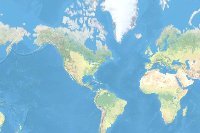

In [67]:
sierra_leone_fgdb = gis.content.search(query="Sierra_Leone*", 
                                       item_type="File Geodatabase")[0]
sierra_leone_fgdb

In [68]:
sle_zip = sierra_leone_fgdb.download(save_path=wd, file_name="sierra_leone_"
                                     + now_dt() + ".zip")

#### Publish the Sierra Leone target hosted feature layer

In [69]:
if not "Sierra Leone" in [folder['title'] 
                          for folder in gis.users.me.folders]:
                         gis.content.create_folder(folder="Sierra Leone")

sle_item = gis.content.add(item_properties = {"title":"sierra_leone_geography_" + now_dt(),
                                              "type":"File Geodatabase",
                                              "tags":"Sierra Leone, West Africa, append guide",
                                              "snippet":"File Geodatabase to illustrate Python API append",
                                              }, folder="Sierra Leone", data=sle_zip)
sle_boundaries = sle_item.publish()

#### Visualize the target feature layer
Notice, that the Southern region is missing data. 

In [70]:
sle_boundaries_lyr = sle_boundaries.layers[0]
sle_boundaries_lyr

<FeatureLayer url:"https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/sierra_leone_geography_1558730610/FeatureServer/0">


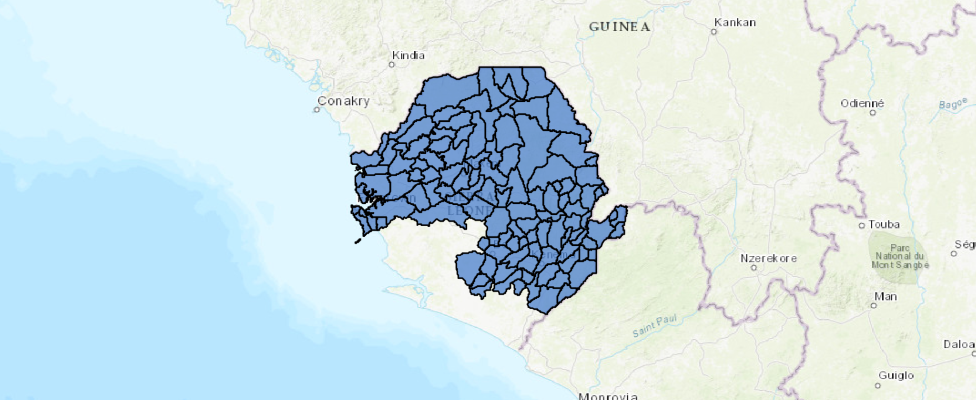

In [73]:
m3 = gis.map("SLE")
m3

In [72]:
m3.add_layer(sle_boundaries_lyr)

#### Query the feature layer to examine attribute errors
We can see that certain features are missing from the southern part of Sierra Leone. We also can query the data to see that certain features of the Bo Chiefdom have been incorrectly labeled as being in the Eastern District. You can also see that certain Bo Chiefdoms have been incorrectly labeled as `Boao`.

You'll use the `Append` function to both:
 1. Insert new missing Chiefdoms in the Southern District
 2. Upsert the correct spelling for `Bo` and change incorrect `Eastern Values` to `Southern`

In [74]:
bo_features = sle_boundaries_lyr.query(where="NAME_2 like 'Bo%' AND \
                                              (NAME_1 = 'Southern' or NAME_1 = 'Eastern')", 
                                       as_df=True)
bo_features[["OBJECTID", "NAME_1", "NAME_2", "GID_3"]]

,OBJECTID,NAME_1,NAME_2,GID_3
0,154,Eastern,Boao,SLE.3.1.1_1
1,155,Eastern,Bo,SLE.3.1.2_1
2,156,Eastern,Bo,SLE.3.1.3_1
3,157,Eastern,Bo,SLE.3.1.4_1
4,158,Southern,Boao,SLE.3.1.5_1
5,159,Southern,Boao,SLE.3.1.6_1
6,160,Southern,Boao,SLE.3.1.7_1
7,161,Southern,Bo,SLE.3.1.8_1
8,162,Southern,Boao,SLE.3.1.9_1
9,163,Southern,Bo,SLE.3.1.10_1


#### Examine attribute fields and indices 
When you are appending to a target feature layer, you need a layer attribute field that has unique values to match a 
field in the source item (a foreign key) from which you'll append features/values.

Generate a list of target feature layer fields with a unique index, then loop over it to examine field names, field types, and whether or not the field contains a unique index.

In [75]:
uk_flds = (f.fields for f in sle_boundaries_lyr.properties.indexes if f.isUnique)

In [76]:
for fld in sle_boundaries_lyr.properties.fields:
    if fld.name in uk_flds:
        print(f"{fld.name:30}{fld.type:25}isUnique")
    else:
        print(f"{fld.name:30}{fld.type:25}")

OBJECTID                      esriFieldTypeOID         isUnique
GID_0                         esriFieldTypeString      
NAME_0                        esriFieldTypeString      
NAME_1                        esriFieldTypeString      
NAME_2                        esriFieldTypeString      
GID_3                         esriFieldTypeString      
TYPE_3                        esriFieldTypeString      
Shape__Area                   esriFieldTypeDouble      
Shape__Length                 esriFieldTypeDouble      


The OBJECTID field in this layer is uniquely indexed, but does not match the OBJECTID values in the file geodatabase that we are
going to append values from. The `GID_3` field is unique to each chiefdom in Sierra Leone. This field exists in both the hosted feature layer and the source file geodatabase, but is not uniquely indexed in this feature layer. 

You need to uniquely index this field in the target hosted feature layer in order to use it for the `upsert_matching_field` parameter.

In [77]:
idx_update_dict ={"name":"gid3_Index","fields":"GID_3","isUnique":True}
sle_boundaries_lyr.manager.add_to_definition({"indexes":[idx_update_dict]})

{'success': True}

Reload the hosted feature layer to ensure there is a unique index:

In [78]:
sle_item = [item 
            for item in gis.content.search(query="sierra_leone_geography_*")
           if item.type == "Feature Service"][0]
sle_boundaries_lyr = sle_item.layers[0]

In [79]:
uk_flds = [f.fields for f in sle_boundaries_lyr.properties.indexes if f.isUnique]

for fld in sle_boundaries_lyr.properties.fields:
    if fld.name in uk_flds:
        print(f"{fld.name:30}{fld.type:25}isUnique")
    else:
        print(f"{fld.name:30}{fld.type:25}")

OBJECTID                      esriFieldTypeOID         isUnique
GID_0                         esriFieldTypeString      
NAME_0                        esriFieldTypeString      
NAME_1                        esriFieldTypeString      
NAME_2                        esriFieldTypeString      
GID_3                         esriFieldTypeString      isUnique
TYPE_3                        esriFieldTypeString      
Shape__Area                   esriFieldTypeDouble      
Shape__Length                 esriFieldTypeDouble      


#### Examine the source file geodatabase

<Item title:"SLE_Southern_Chiefdoms" type:File Geodatabase owner:api_data_owner>
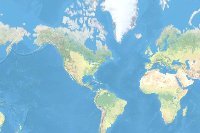

In [80]:
sle_southern_chiefdoms = gis.content.search("SLE_Southern*")[0]
sle_southern_chiefdoms

Download the File Geodatabase that is the source for your append data. We can use `arcpy` to get the name of the feature class and its fields because we'll need those as arguments to the `append` function.

In [81]:
sle_southern_zip = sle_southern_chiefdoms.download(save_path=wd, file_name="sierra_leone_southern.zip")

with zipfile.ZipFile(sle_southern_zip) as zf:
    zf.extractall(wd)

In [82]:
sle_southern_chiefdoms_fgdb = [os.path.join(wd, gdb) 
                               for gdb in os.listdir(wd)
                               if gdb.startswith("SLE")][0]
sle_southern_chiefdoms_fgdb

'DRIVE:\\\\Path\\To\\Data\\append_guide\\sierra_leone\\SLE_Southern_Chiefdoms.gdb'

In [83]:
# Get the feature class name for the `source_table_name` parameter

arcpy.env.workspace = sle_southern_chiefdoms_fgdb
print(f"Root Geodatabase")
if arcpy.ListFeatureClasses():
    for fc in arcpy.ListFeatureClasses():
        print(f"\t{fc}")
if arcpy.ListDatasets():
    for ds in arcpy.ListDatasets():
        if arcpy.ListFeatureClasses(feature_dataset=ds):
            print(f"{'':2}FDS: {ds}")
            for fc in arcpy.ListFeatureClasses(feature_dataset=ds):
                print(f"\t{fc}")

Root Geodatabase
	Chiefdoms_Southern


In [84]:
# inspect the field names because you'll need certain fields for the `append_fields`
# and the `field_mappings` parameters

for fc in arcpy.ListFeatureClasses():
    sle_southern_desc = arcpy.Describe(fc)

for ch_fld in sle_southern_desc.fields:
    print(f"{ch_fld.name:30}{ch_fld.type}")
print("\n")
for ch_idx in sle_southern_desc.indexes:
    if ch_idx.isUnique:
        uk = "Unique index on: "
    else:
        uk = "Non-Unique index on: "
    print(f"{ch_idx.name:20}{uk:<20}{[f.name for f in ch_idx.fields]}")

OBJECTID                      OID
Shape                         Geometry
GID_0                         String
NAME_0                        String
NAME_1                        String
NAME_2                        String
GID_3                         String
TYPE_3                        String
Shape_Length                  Double
Shape_Area                    Double


FDO_OBJECTID        Unique index on:    ['OBJECTID']
FDO_Shape           Non-Unique index on: ['Shape']


#### Append using `upsert` to update attribute values and add new features

The `Chiefdoms_Southern` feature class contains edits for Bo Chiefdom features where the name is misspelled in the `Name_2` attribute and the incorrect region is labeled in the `Name_1` attribute. The feature class also contains all the missing chiefdom features to complete the Southern region.

You'll use the `append_fields` parameter to match values between the source and target (`GID_3` in both datasets), as well as inform the function on which fields should have values updated (`NAME_1` and `NAME_2`). The `upsert_matching_field` informs the server of the matching fields between the datasets. If the field names differed between sources, the `field_mappings` parameter allows alignment between the fields.

In [85]:
sle_boundaries_lyr.append(source_table_name ="Chiefdoms_Southern",
                          item_id=sle_southern_chiefdoms.id,
                          upload_format="filegdb",
                          upsert=True,
                          skip_updates=False,
                          use_globalids=False,
                          update_geometry=True,
                          append_fields=["GID_3","NAME_1", "NAME_2"],
                          rollback=False,
                          skip_inserts=False,
                          upsert_matching_field="GID_3")

True

_Verify results_


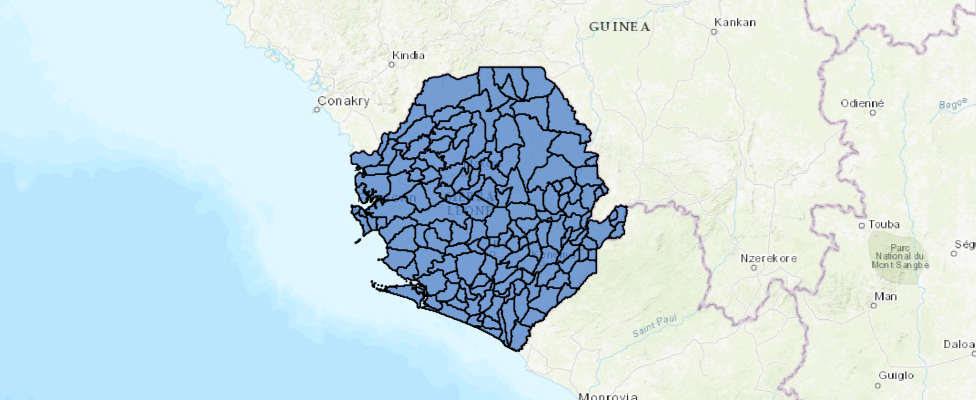

In [88]:
m4 = gis.map("SLE")
m4

In [87]:
m4.add_layer(sle_boundaries_lyr)

In [89]:
bo_append_features = sle_boundaries_lyr.query(where="NAME_2 like 'Bo' AND \
                                              (NAME_1 = 'Southern' OR NAME_1 = 'Eastern')",
                                             as_df=True)
bo_append_features

,GID_0,GID_3,NAME_0,NAME_1,NAME_2,OBJECTID,SHAPE,Shape__Area,Shape__Length,TYPE_3
0,SLE,SLE.3.1.1_1,Sierra Leone,Southern,Bo,154,"{""rings"": [[[-1273681.0309, 896109.3464], [-12...",1.239438e+08,45455.250384,Chiefdom
1,SLE,SLE.3.1.2_1,Sierra Leone,Southern,Bo,155,"{""rings"": [[[-1281851.8307, 892253.52], [-1281...",2.429076e+08,67019.126611,Chiefdom
2,SLE,SLE.3.1.3_1,Sierra Leone,Southern,Bo,156,"{""rings"": [[[-1306553.6242, 855184.083099999],...",2.607698e+08,88729.800647,Chiefdom
3,SLE,SLE.3.1.4_1,Sierra Leone,Southern,Bo,157,"{""rings"": [[[-1297829.6114, 877901.4813], [-12...",4.414146e+08,115758.103473,Chiefdom
4,SLE,SLE.3.1.5_1,Sierra Leone,Southern,Bo,158,"{""rings"": [[[-1344836.3667, 860856.6523], [-13...",1.025333e+09,138072.230896,Chiefdom
5,SLE,SLE.3.1.6_1,Sierra Leone,Southern,Bo,159,"{""rings"": [[[-1310828.2589, 901460.828600001],...",1.660301e+08,49260.324265,Chiefdom
6,SLE,SLE.3.1.7_1,Sierra Leone,Southern,Bo,160,"{""rings"": [[[-1305017.4523, 855240.213100001],...",4.293123e+08,104077.943988,Chiefdom
7,SLE,SLE.3.1.8_1,Sierra Leone,Southern,Bo,161,"{""rings"": [[[-1297829.6114, 877901.4813], [-12...",4.590913e+08,95926.942063,Chiefdom
8,SLE,SLE.3.1.9_1,Sierra Leone,Southern,Bo,162,"{""rings"": [[[-1266100.1763, 911052.4463], [-12...",2.519861e+08,77495.153980,Chiefdom
9,SLE,SLE.3.1.10_1,Sierra Leone,Southern,Bo,163,"{""rings"": [[[-1335218.3591, 848568.755800001],...",2.613595e+08,75448.219786,Chiefdom


## Conclusion

You used the Feature Layer `append()` method to perform inserts of new features and updates of existing features. Particularly for large feature service layers, the append operation provides performance benefits to overwriting services. Using append can ease the challenge of managing data, providing flexiblity for updating your service data.